<a href="https://colab.research.google.com/github/TobyHerlong/Finance/blob/main/Technical_Analysis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is designed to perform a technical analysis of stock data, specifically focusing on candlestick patterns and their combination with moving averages to generate trading signals. It includes the following key aspects:

*   **Data Download**: It downloads historical OHLC (Open, High, Low, Close) stock data for a given ticker using the `yfinance` library.
*   **Candlestick Pattern Detection**: It implements vectorized functions to detect various candlestick patterns, such as Hammer, Green Hammer, Inverted Hammer, Shooting Star, Hanging Man, Doji, Bullish Engulfing, and Bearish Engulfing.
*   **Moving Average Calculation**: It calculates the 50-day moving average (50-MA) of the stock's closing price.
*   **Trading Signal Generation**: It defines a specific buy signal: a 'Green Hammer' candlestick pattern occurring when the closing price is above the 50-day moving average.
*   **Data Visualization**: It plots the candlestick chart along with the 50-day moving average and highlights the generated buy signals.
*   **Signal Summary**: It provides a text summary of the counts of each detected candlestick pattern and the most recent occurrences of these patterns.
*   **Backtesting**: It includes a simple backtesting function to evaluate the performance of the generated trading signals over a specified horizon, calculating metrics like mean return, total return, and hit rate.

In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd

# Define the stock ticker and the date range
ticker = 'HCKT'
start_date = '2020-01-01'  # Set your desired start date
end_date = '2023-10-01'    # Set your desired end date

# Download the historical stock price data
hckt_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

# Display the first few rows of the data
print(hckt_data.head())

# Optionally, save the data to a CSV file
hckt_data.to_csv('HCKT_stock_prices.csv')

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open  Volume
Ticker           HCKT       HCKT       HCKT       HCKT       HCKT    HCKT
Date                                                                     
2020-01-02  14.154998  16.059999  16.230000  15.750000  16.170000  117600
2020-01-03  14.331277  16.260000  16.280001  15.940000  15.940000  104800
2020-01-06  14.437040  16.379999  16.459999  15.960000  16.190001  127800
2020-01-07  14.357718  16.290001  16.379999  16.139999  16.360001  241800
2020-01-08  14.366531  16.299999  16.549999  16.190001  16.309999  142700


Plot the data and show candlestick pattern.

In [ ]:
import plotly.graph_objects as go

# Assuming 'hckt_data' is the DataFrame downloaded in the previous cell
# If you re-ran the notebook, you might need to load it from the CSV:
# hckt_data = pd.read_csv('HCKT_stock_prices.csv', index_col='Date', header=[0, 1])


fig = go.Figure(data=[go.Candlestick(x=hckt_data.index,
                open=hckt_data[('Open', 'HCKT')],
                high=hckt_data[('High', 'HCKT')],
                low=hckt_data[('Low', 'HCKT')],
                close=hckt_data[('Close', 'HCKT')])])

fig.update_layout(title='HCKT Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible=False)

fig.show()

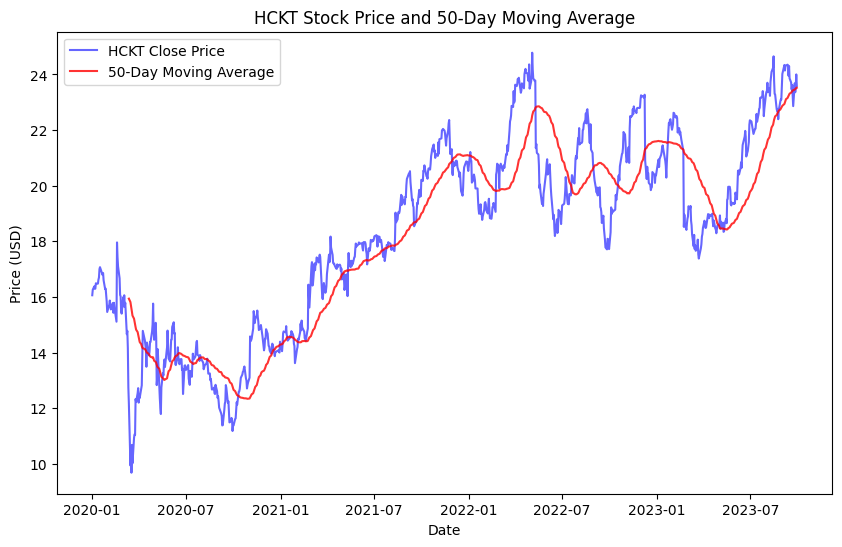

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Assuming hckt_data is already loaded from the previous cell
# If you re-ran the notebook, you might need to load it from the CSV:
# hckt_data = pd.read_csv('HCKT_stock_prices.csv', index_col='Date', header=[0, 1])


# Calculate the 50-day moving average for HCKT
hckt_data['50_MA'] = hckt_data[('Close', 'HCKT')].rolling(window=50).mean()

# Plot the closing prices and 50-day moving average for HCKT
plt.figure(figsize=(10, 6))
plt.plot(hckt_data.index, hckt_data[('Close', 'HCKT')], label='HCKT Close Price', color='blue', alpha=0.6)
plt.plot(hckt_data.index, hckt_data['50_MA'], label='50-Day Moving Average', color='red', alpha=0.8)

# Add plot labels and title
plt.title('HCKT Stock Price and 50-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Calculate the 50-day moving average
hckt_data['50_MA'] = hckt_data[('Close', 'HCKT')].rolling(window=50).mean()

# Define the green hammer pattern conditions
def is_green_hammer(open_price, high_price, low_price, close_price):
    # Ensure all inputs are scalar before calculations
    open_price = open_price.item() if isinstance(open_price, pd.Series) else open_price
    high_price = high_price.item() if isinstance(high_price, pd.Series) else high_price
    low_price = low_price.item() if isinstance(low_price, pd.Series) else low_price
    close_price = close_price.item() if isinstance(close_price, pd.Series) else close_price

    # Body is small
    body_range = abs(close_price - open_price)
    total_range = high_price - low_price
    if total_range == 0:
        return False # Avoid division by zero
    if (body_range / total_range) > 0.3: # Adjust threshold as needed
        return False
    # Lower shadow is at least twice the body
    lower_shadow = min(open_price, close_price) - low_price
    if lower_shadow < 2 * body_range:
        return False
    # Upper shadow is small or non-existent
    upper_shadow = high_price - max(open_price, close_price)
    if (upper_shadow / total_range) > 0.1: # Adjust threshold as needed
        return False
    # Candlestick is green (close is higher than open)
    if close_price <= open_price:
        return False
    return True

# Generate the trading signal
hckt_data['Signal'] = 0.0
# Start the loop after the 50-day moving average has enough data
for i in range(50, len(hckt_data)):
    open_price = hckt_data[('Open', 'HCKT')].iloc[i]
    high_price = hckt_data[('High', 'HCKT')].iloc[i]
    low_price = hckt_data[('Low', 'HCKT')].iloc[i]
    close_price = hckt_data[('Close', 'HCKT')].iloc[i]
    sma_50 = hckt_data['50_MA'].iloc[i]

    # Ensure sma_50 is not NaN before checking the signal
    if not pd.isna(sma_50) and \
       is_green_hammer(open_price, high_price, low_price, close_price) and \
       close_price > sma_50:
        hckt_data.loc[hckt_data.index[i], 'Signal'] = 1.0 # Buy signal

display(hckt_data.tail())

Price,Adj Close,Close,High,Low,Open,Volume,50_MA,Signal
Ticker,HCKT,HCKT,HCKT,HCKT,HCKT,HCKT,,
Date,,,,,,,,
2023-09-25,22.676914,23.680000,23.730000,22.700001,22.889999,105400,23.4566,0.0
2023-09-26,22.370466,23.360001,23.670000,23.320000,23.520000,63100,23.4720,0.0
2023-09-27,22.609879,23.610001,23.770000,23.370001,23.440001,72300,23.4890,0.0
2023-09-28,22.983355,24.000000,24.150000,23.610001,23.670000,105600,23.5130,0.0
2023-09-29,22.590723,23.590000,24.049999,23.549999,24.010000,196300,23.5216,0.0


=== Signal Counts ===
GreenHammer       : 19
Hammer            : 38
InvertedHammer    : 37
ShootingStar      : 37
HangingMan        : 38
Doji              : 166
BullishEngulfing  : 63
BearishEngulfing  : 65
Signal            : 12

=== Most Recent Occurrences ===

GreenHammer:
  2025-10-01  O=18.94 H=19.05 L=18.74 C=19.02
  2025-09-08  O=20.94 H=21.02 L=20.68 C=20.99
  2024-11-20  O=30.38 H=30.58 L=29.99 C=30.55
  2024-11-05  O=27.60 H=28.68 L=25.36 C=28.62
  2024-06-14  O=21.75 H=21.86 L=21.54 C=21.83
  2024-02-28  O=24.90 H=25.01 L=24.55 C=24.99
  2024-02-14  O=23.35 H=23.42 L=23.04 C=23.40
  2023-09-05  O=24.03 H=24.35 L=23.35 C=24.34
  2023-07-19  O=22.71 H=22.84 L=21.97 C=22.80
  2023-01-25  O=22.14 H=22.22 L=21.61 C=22.19

Hammer:
  2025-12-02  O=18.84 H=18.84 L=18.62 C=18.81
  2025-10-09  O=19.14 H=19.14 L=18.83 C=19.09
  2025-10-01  O=18.94 H=19.05 L=18.74 C=19.02
  2025-09-08  O=20.94 H=21.02 L=20.68 C=20.99
  2025-01-15  O=30.15 H=30.19 L=29.47 C=30.00
  2024-11-20  O=30.38 H=

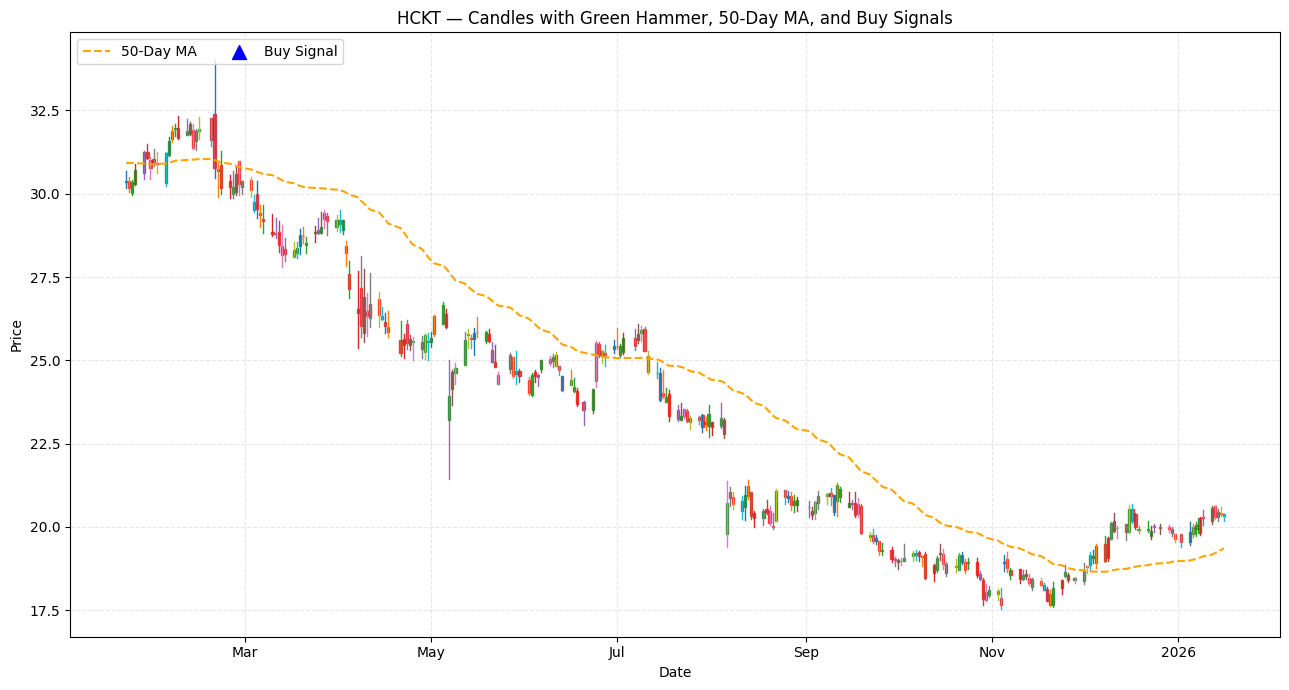


=== Backtest Results (Horizon = 5 trading days) ===
Trades: 5
Mean Return: 0.0042
Median Return: 0.0079
Total Return: 0.0208
Hit Rate (>0): 80.00%
Sharpe Ratio (annualized): 2.29


In [ ]:
# Candlestick signal detector & plotter (fixed for pandas Series comparisons)
# --------------------------------------------------------------------------
# pip install yfinance pandas matplotlib numpy python-dateutil

import datetime as dt
from dateutil.relativedelta import relativedelta
import re
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

# ----------------------------
# 1) Data download (robust)
# ----------------------------
def download_ohlc(ticker="HCKT", years=5, interval="1d"):
    end = dt.datetime.today()
    start = end - relativedelta(years=years)
    df = yf.download(
        ticker, start=start, end=end, interval=interval,
        progress=False, auto_adjust=False, group_by="column"
    )
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ["_".join([str(x) for x in tup if x]) for tup in df.columns]

    def map_col(base):
        pat = re.compile(rf"^{base}(?:[_\-].+)?$", re.IGNORECASE)
        for c in df.columns:
            if pat.match(c.replace(" ", "")):
                return c
        return None

    cols = {k: map_col(k) for k in ["Open","High","Low","Close","Volume"]}
    missing = [k for k,v in cols.items() if v is None and k!="Volume"]
    if missing:
        raise ValueError(f"Missing columns: {missing}. Got: {list(df.columns)}")

    out = df[[cols["Open"], cols["High"], cols["Low"], cols["Close"]]].copy().dropna()
    out.columns = ["Open","High","Low","Close"]
    if getattr(out.index, "tz", None) is not None:
        out.index = out.index.tz_convert(None)
    return out

# ----------------------------
# 2) Vector helpers (all Series → Series)
# ----------------------------
def body(o, c):
    return (c - o).abs()

def upper_shadow(o, h, c):
    return h - np.maximum(o, c)

def lower_shadow(o, l, c):
    return np.minimum(o, c) - l

def body_pos_frac(o, c, h, l):
    """
    Position of body midpoint within the full range, as a fraction from the top.
    0 == top, 1 == bottom. Vectorized.
    """
    rng = (h - l).replace(0, np.nan)
    mid = (o + c) / 2.0
    return (h - mid) / rng

# ----------------------------
# 3) Signal definitions (vectorized)
# ----------------------------
def detect_signals(df, use_atr_filter=True, atr_window=14):
    d = df.copy()
    o, h, l, c = d["Open"], d["High"], d["Low"], d["Close"]
    rng = (h - l)

    # ATR (to filter out tiny candles)
    tr = pd.concat([(h - l), (h - c.shift()).abs(), (l - c.shift()).abs()], axis=1).max(axis=1)
    atr = tr.rolling(atr_window, min_periods=atr_window//2).mean()
    min_range = (0.5 * atr) if use_atr_filter else 0.0

    # Thresholds
    max_body_frac   = 0.33
    min_shadow_ratio= 2.0
    tiny_upper_frac = 0.10
    tiny_lower_frac = 0.10
    doji_body_frac  = 0.05

    body_series  = body(o, c) # Renamed from body
    us_series = upper_shadow(o, h, c) # Renamed from upper_shadow
    ls_series = lower_shadow(o, l, c) # Renamed from lower_shadow

    # Avoid /0
    rng_nz = rng.replace(0, np.nan)
    b_nz   = body_series.replace(0, np.nan) # Use body_series

    body_frac   = body_series / rng_nz # Use body_series
    us_frac     = us_series / rng_nz # Use us_series
    ls_frac     = ls_series / rng_nz # Use ls_series
    ls_over_body= ls_series / b_nz # Use ls_series and b_nz
    us_over_body= us_series / b_nz # Use us_series and b_nz
    pos         = body_pos_frac(o, c, h, l)

    # Vectorized boolean masks
    big_enough = rng >= min_range

    hammer = (
        big_enough &
        (body_frac <= max_body_frac) &
        (ls_over_body >= min_shadow_ratio) &
        (us_frac <= tiny_upper_frac) & # Use us_frac
        (pos <= 0.35)   # body near top
    )

    green_hammer     = hammer & (c > o)
    inverted_hammer  = big_enough & (body_frac <= max_body_frac) & (us_over_body >= min_shadow_ratio) & (ls_frac <= tiny_lower_frac) & (pos >= 0.65) # Use us_over_body and ls_frac
    shooting_star    = inverted_hammer
    hanging_man      = hammer
    doji             = big_enough & (body_series <= doji_body_frac) # Use body_series

    prev_o, prev_c = o.shift(1), c.shift(1)
    bullish_engulf = (prev_c < prev_o) & (c > o) & (o <= prev_c) & (c >= prev_o)
    bearish_engulf = (prev_c > prev_o) & (c < o) & (o >= prev_c) & (c <= prev_o)

    d["Hammer"]           = hammer.fillna(False)
    d["GreenHammer"]      = green_hammer.fillna(False)
    d["InvertedHammer"]   = inverted_hammer.fillna(False)
    d["ShootingStar"]     = shooting_star.fillna(False)
    d["HangingMan"]       = hanging_man.fillna(False)
    d["Doji"]             = doji.fillna(False)
    d["BullishEngulfing"] = bullish_engulf.fillna(False)
    d["BearishEngulfing"] = bearish_engulf.fillna(False)

    # Calculate 50-day moving average
    d["50_MA"] = d["Close"].rolling(window=50).mean()

    # Create combined signal: Green Hammer and Close above 50_MA
    d["Signal"] = (d["GreenHammer"]) & (d["Close"] > d["50_MA"]) & (~d["50_MA"].isna())

    return d

# ----------------------------
# 4) Plotting
# ----------------------------
def plot_candles_with_signals(d, title="", last_n=250):
    data  = d.tail(last_n).copy()
    dates = mdates.date2num(data.index.to_pydatetime())
    o, h, l, c = data["Open"].to_numpy(), data["High"].to_numpy(), data["Low"].to_numpy(), data["Close"].to_numpy()
    signal = data["Signal"].to_numpy() # Get signal data

    fig, ax = plt.subplots(figsize=(13, 7))
    bar_width = 0.7  # days

    # Candles
    for x, _o, _h, _l, _c in zip(dates, o, h, l, c):
        ax.plot([x, x], [_l, _h], linewidth=1)
        lower = min(_o, _c)
        height = abs(_c - _o)
        color = "green" if _c >= _o else "red"
        ax.add_patch(Rectangle((x - bar_width/2, lower),
                               bar_width, height if height != 0 else 1e-9,
                               linewidth=1, edgecolor=color, facecolor=color, alpha=0.7))

    # Plot 50-day moving average
    ax.plot(dates, data["50_MA"].to_numpy(), label="50-Day MA", color="orange", linestyle="--")

    # Mark the combined signal
    signal_dates = dates[signal]
    signal_prices = c[signal]
    ax.scatter(signal_dates, signal_prices * 1.02, marker="^", color="blue", s=100, label="Buy Signal")


    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.grid(True, which="major", linestyle="--", alpha=0.3)
    ax.set_title(title or "Candles with Pattern Signals")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc="upper left", ncol=2, frameon=True)

    plt.tight_layout()
    plt.show()

# ----------------------------
# 5) Text summary
# ----------------------------
def summarize_signals(d, top_n=10):
    cols = ["GreenHammer","Hammer","InvertedHammer","ShootingStar","HangingMan","Doji","BullishEngulfing","BearishEngulfing", "Signal"] # Added "Signal"
    print("=== Signal Counts ===")
    for c in cols:
        print(f"{c:18s}: {int(d[c].sum())}")
    print("\n=== Most Recent Occurrences ===")
    for c in cols:
        hits = d.index[d[c]]
        if len(hits) > 0:
            recent = hits[-top_n:]
            print(f"\n{c}:")
            for t in recent[::-1]:
                row = d.loc[t]
                print(f"  {t.date()}  O={row['Open']:.2f} H={row['High']:.2f} L={row['Low']:.2f} C={row['Close']:.2f}")

# ----------------------------
# 6) Backtest
# ----------------------------
def backtest(df, horizon=5):
    signal_dates = df.index[df["Signal"].fillna(False)]
    returns = []
    for date in signal_dates:
        try:
            # Buy at the open of the next day
            entry_date = date + pd.Timedelta(days=1)
            entry_price = df.loc[entry_date, "Open"]

            # Sell at the close after the specified horizon
            exit_date = date + pd.Timedelta(days=horizon)
            exit_price = df.loc[exit_date, "Close"]

            ret = (exit_price - entry_price) / entry_price
            returns.append(ret)
        except KeyError:
            # Handle cases where the entry or exit date is outside the data range
            continue

    returns = pd.Series(returns)

    print(f"\n=== Backtest Results (Horizon = {horizon} trading days) ===")
    print(f"Trades: {len(returns)}")
    if len(returns) > 0:
        print(f"Mean Return: {returns.mean():.4f}")
        print(f"Median Return: {returns.median():.4f}")
        print(f"Total Return: {(1 + returns).prod() - 1:.4f}") # Calculate total return
        print(f"Hit Rate (>0): {(returns > 0).mean():.2%}")
        if returns.std() != 0:
            print(f"Sharpe Ratio (annualized): {(returns.mean() / returns.std()) * np.sqrt(252 / horizon):.2f}")
        else:
            print("Sharpe Ratio (annualized): N/A (standard deviation is zero)")
    else:
        print("No trades generated by the signal.")


# ----------------------------
# 7) Run
# ----------------------------
if __name__ == "__main__":
    TICKER  = "HCKT"
    YEARS   = 5
    INTERVAL= "1d"

    ohlc = download_ohlc(TICKER, years=YEARS, interval=INTERVAL)
    det  = detect_signals(ohlc, use_atr_filter=True, atr_window=14)

    summarize_signals(det)
    plot_candles_with_signals(det, title=f"{TICKER} — Candles with Green Hammer, 50-Day MA, and Buy Signals", last_n=250)
    backtest(det, horizon=5) # Perform backtest with a 5-day horizon